In [1]:
import os

## switch to the root dir

In [2]:
os.chdir('..')
os.listdir()

['.git',
 '.gitignore',
 '.idea',
 'data_loader',
 'data_processor',
 'jupyter',
 'loggers',
 'main.py',
 'models',
 'original_data',
 'processed_data',
 'README.md',
 'saved_models',
 'trainers']

In [3]:
from data_processor.utils import load_numpy_arrays, numpy_to_tensor
from models.Linear import LogisticRegression
import trainers.SGD_trainer
from loggers.statistics_loggers import plot_numerical_arrays
import torch
from torch import nn
from speechbrain.lobes.models.CRDNN import CRDNN

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


## Load preprocessed data

In [4]:
X_train, y_train, X_val, y_val = load_numpy_arrays(['data_train_X.npy','data_train_y.npy', 'data_val_X.npy','data_val_y.npy']
                  , path_prefix='processed_data/processed_waves/4-genres/')

In [5]:
X_train, y_train, X_val, y_val = numpy_to_tensor([X_train, y_train, X_val, y_val])

In [6]:
y_train = y_train.type(torch.int64)
y_val = y_val.type(torch.int64)

In [7]:
print(X_train.shape)
print(y_train.shape)

torch.Size([640, 501, 20])
torch.Size([640])


In [8]:
print(X_train[0])
print(y_train[0])

tensor([[-2.6793, -3.5519, -4.7389,  ..., -3.0967, -3.5594, -3.4670],
        [-3.1634, -3.8503, -4.6526,  ..., -2.4343, -2.6496, -2.7823],
        [-2.8878, -3.4747, -4.8224,  ..., -2.5756, -2.5007, -2.7433],
        ...,
        [-0.2473,  0.0616,  0.4944,  ..., -0.8849, -1.0255, -0.9458],
        [-0.1621,  0.0802,  0.1030,  ..., -0.9531, -0.9674, -0.9041],
        [-0.2025, -0.1149,  0.0338,  ..., -0.2389, -0.2379, -0.1873]])
tensor(1)


In [9]:
print(X_val.shape)
print(y_val.shape)

torch.Size([80, 501, 20])
torch.Size([80])


## Load model

1. define model under the folder models
2. import and define the model

In [10]:
class simple_CRDNN(nn.Module):
    def __init__(self):
        super(simple_CRDNN, self).__init__()
        self.leakyReLU = nn.LeakyReLU(negative_slope=0.01)
        
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 4,
            kernel_size = (5, 5),
            stride = (1, 1),
            padding = (2, 2)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels = 4,
            out_channels = 8,
            kernel_size = (5, 5),
            stride = (1, 1),
            padding = (2, 2)
        )
        self.pool2 = nn.AvgPool2d(kernel_size=(4, 4), stride=(2,2))
        
        self.LSTM = nn.LSTM(input_size=24, hidden_size=36, num_layers=8, dropout=0.15, batch_first=True)
        self.linear1 = nn.Linear(36, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 4)
        
        
    
    def forward(self, x):
        out = self.leakyReLU(self.conv1(x))
        out = self.pool1(out)
        out = self.leakyReLU(self.conv2(out))
        out = self.pool2(out)
        out = torch.flatten(torch.transpose(out, 1, 2), 2)
        H, h_n = self.LSTM(out)
        out = self.leakyReLU(self.linear1(H[:, -1, :]))
        out = self.leakyReLU(self.linear2(out))
        out = self.leakyReLU(self.linear3(out))
        return out

In [11]:
# eg. MLP
model = simple_CRDNN()

In [12]:
n_feat = X_train.shape[2]
n_time = X_train.shape[1]

In [13]:
X_a = X_train[:10].reshape((-1, 1, n_time, n_feat))
pred = model(X_a)

## Define loss and optimizer

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

## Train

use trainers.SGD_trainer.train or define a trainer

parameters of SGD_trainer.train
- model
- train_array: a tuple (X_train, y_train, X_val, y_val)
- loss
- optimizer
- batch_size
- num_epoch
- device

In [15]:
X_train_2d = X_train.reshape((-1, 1, n_time, n_feat))
print(X_train.shape)
X_val_2d = X_val.reshape((-1, 1, n_time, n_feat))
training_loss_array, training_accuracy_array, validation_loss_array, validation_accuracy_array = trainers.SGD_trainer.train(model, (X_train_2d, y_train, X_val_2d, y_val), 
                                                                                                                            loss, optimizer, batch_size=50, num_epoch=20, device='cuda')

torch.Size([640, 501, 20])
Epoch  0: loss on final training batch: 1.5139
training accuracy: 25.78% validation accuracy: 17.50%
Epoch  1: loss on final training batch: 1.3890
training accuracy: 25.00% validation accuracy: 26.25%
Epoch  2: loss on final training batch: 1.3935
training accuracy: 25.00% validation accuracy: 26.25%
Epoch  3: loss on final training batch: 1.3949
training accuracy: 25.00% validation accuracy: 26.25%
Epoch  4: loss on final training batch: 1.3950
training accuracy: 25.47% validation accuracy: 20.00%
Epoch  5: loss on final training batch: 1.3945
training accuracy: 25.31% validation accuracy: 20.00%
Epoch  6: loss on final training batch: 1.3943
training accuracy: 25.31% validation accuracy: 20.00%
Epoch  7: loss on final training batch: 1.3938
training accuracy: 25.31% validation accuracy: 20.00%
Epoch  8: loss on final training batch: 1.3938
training accuracy: 25.31% validation accuracy: 20.00%
Epoch  9: loss on final training batch: 1.3929
training accuracy

## Plot

plot_numerical_arrays: plot multiple arrays with the same length

parameters:
- num_arrays: numerical arrays with the same length
- labels: labels of each array(with the same order of num_arrays)
- xlabel
- ylabel
- title

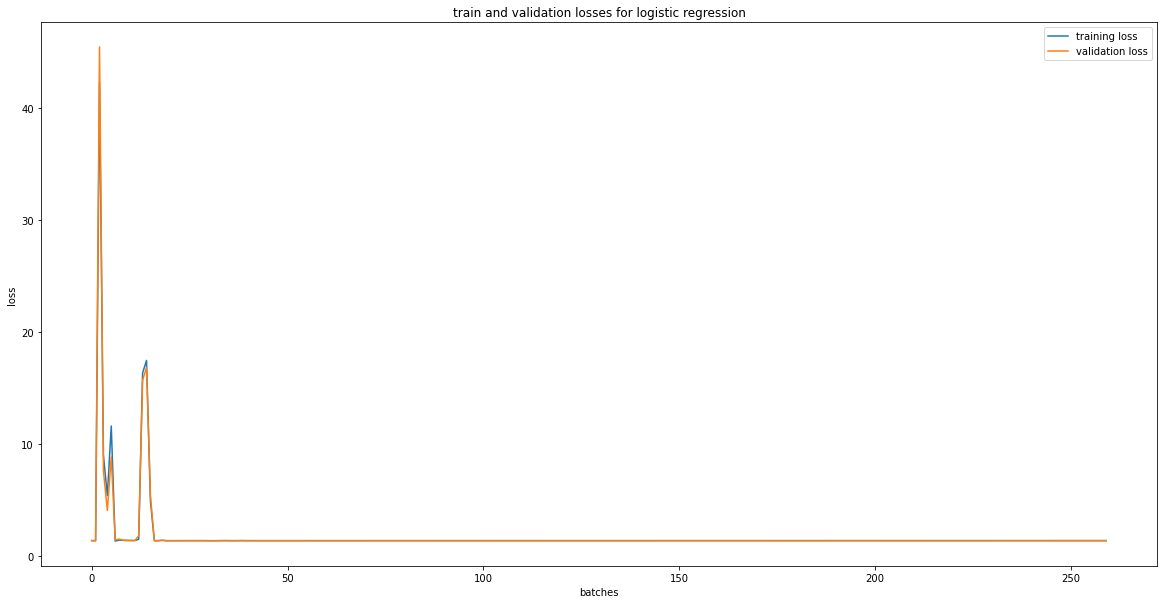

In [16]:
plot_numerical_arrays([training_loss_array, validation_loss_array], ['training loss', 'validation loss'], 
                      xlabel='batches', ylabel='loss', title='train and validation losses for logistic regression')

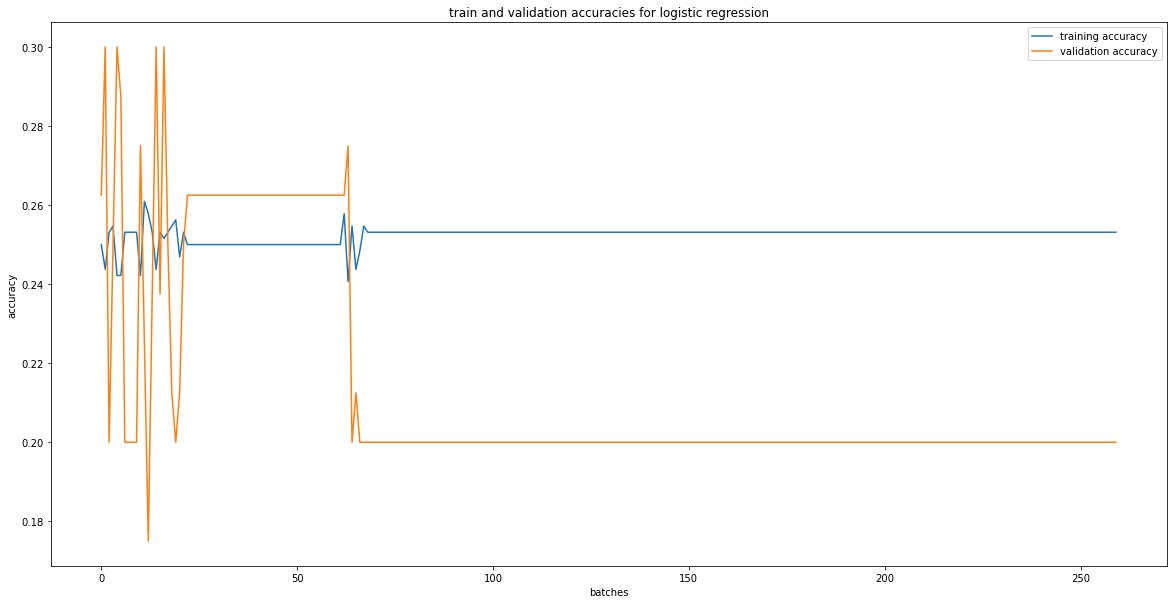

In [17]:
plot_numerical_arrays([training_accuracy_array, validation_accuracy_array], ['training accuracy', 'validation accuracy'], 
                      xlabel='batches', ylabel='accuracy', title='train and validation accuracies for logistic regression')

## Save model

Save model in 'saved_models/saved_modelname_wave.pt'

In [18]:
torch.save(model.state_dict(), 'saved_models/saved_MLP_wave.pt')